# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import pprint
from itertools import combinations
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import HTML, Markdown, clear_output
from sklearn import datasets, decomposition
from tqdm.auto import tqdm

In [2]:
from example_aencoders import autoencoder_factory

from polcanet import PolcaNet

In [ ]:
np.random.seed(5)

In [102]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load iris dataset

In [4]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

### Fit standard sklearn PCA

In [5]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
Xpca = pca.transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

### Fit POLCANet

In [68]:
ae_input = X
act_fn = torch.nn.Mish()

aencoder_iris = autoencoder_factory(
    input_dim=ae_input.shape[1],
    latent_dim=ae_input.shape[1],
    hidden_dim=64,
    num_layers=2,
    autoencoder_type="dense",
    act_fn=act_fn,
)

model_iris = PolcaNet(
    model=aencoder_iris,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda:0",
)
model_iris

PolcaNet(
  (model): BaseAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Mish()
      (2): ResNet(
        (module): Linear(in_features=64, out_features=64, bias=True)
      )
      (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (4): Mish()
      (5): Linear(in_features=64, out_features=4, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Mish()
      (2): ResNet(
        (module): Linear(in_features=64, out_features=64, bias=True)
      )
      (3): Mish()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (reconstruction_loss_fn): MSELoss()
)

In [70]:
model_iris.to("cuda:0")
model_iris.train_model(data=X, batch_size=1 * 512, num_epochs=10000, report_freq=100, lr=0.001)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.08183
decode: 0.002774
orth: 0.3525
com: 0.02564
var: 0.01811


In [71]:
model_iris.train_model(data=X, batch_size=1 * 512, num_epochs=10000, report_freq=100, lr=0.0001)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.07711
decode: 0.0003311
orth: 0.3373
com: 0.02378
var: 0.01927


## Evaluate results

In [72]:
latents, reconstructed = model_iris.predict(X)

In [73]:
model_iris.analyze_latent_space(latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 4
Total variance in latent space: 1.8369

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.6471
First 5 components              1
Components for 95% variance     2
Variance Concentration Metric   0.9095

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Correlation Analysis
------------------------------
Metric                                Value
----------------------------------  -------
Mean absolute off-diagonal           0.2027
Median absolute off-diagonal         0.0643
Max absolute off-diagonal            0.9667
Proportion of |correlations| > 0.1   0.3333
Decorrelation Success Metric         0.7973

Decorrelation Interpretation:
Good decorrelation, but there might be room for impr

/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


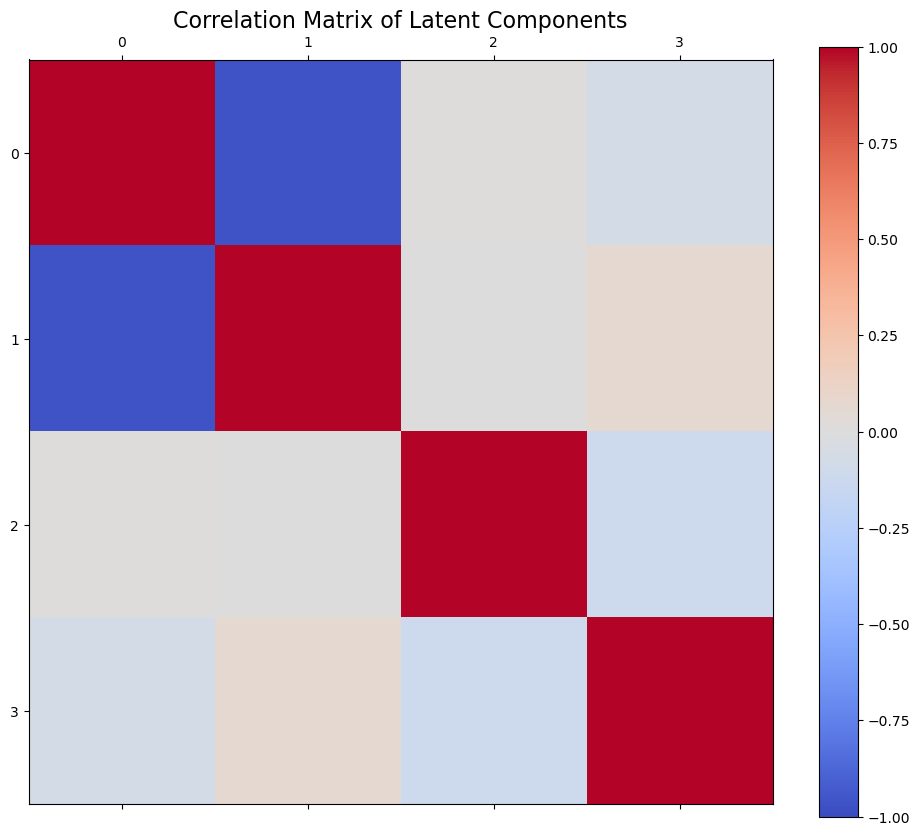

In [74]:
model_iris.show_correlation_matrix(latents)

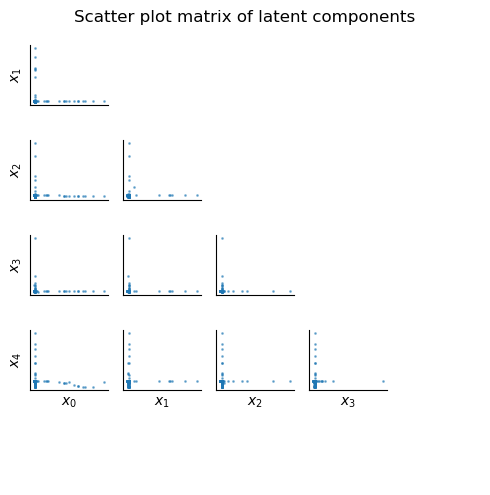

In [101]:
model_iris.plot_scatter_corr_matrix(latents)

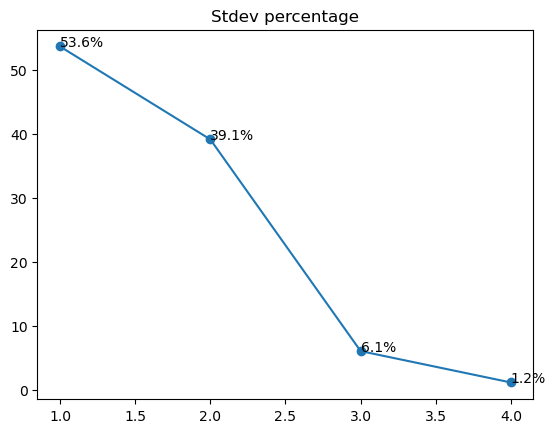

In [76]:
model_iris.plot_stdev_pct()

(1) reconstruction error: 4.2938, variance: 100.0%, with      1  active latent components
(2) reconstruction error: 0.1914, variance: 95.5%, with      2  active latent components
(3) reconstruction error: 0.0236, variance: 99.8%, with      3  active latent components
(4) reconstruction error: 0.0003, variance: 100.0%, with      4  active latent components


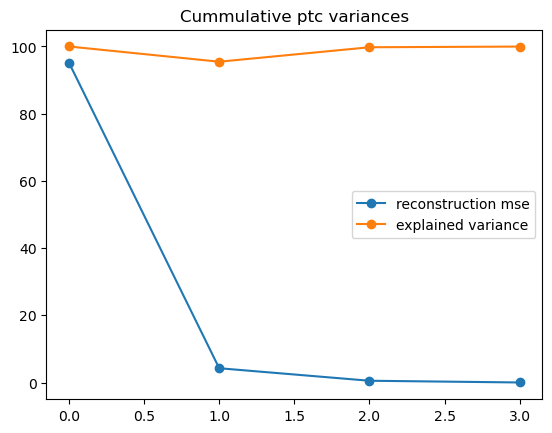

In [77]:
model_iris.plot_cumsum_variance(X)

### Polca Net vs. PCA

In [78]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
        ax.scatter(X[y == label, 0], X[y == label, 1], label=name)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [79]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    fig, ax = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    fig, ax = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [80]:
o1 = widgets.Output()
o2 = widgets.Output()
o3 = widgets.Output()
o4 = widgets.Output()

with o1:
    fig1, ax1 = plot2d_analysis(X, y, "Original data two first componets", legend=False)

with o2:
    fig2, ax2 = plot2d_analysis(pca.inverse_transform(Xpca), y, "Reconstructed with PCA two componets", legend=False)

with o3:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 0, 0]))
    fig3, ax3 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA two componets", legend=False)

with o4:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 1, 1]))
    fig4, ax4 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA all componets", legend=False)


layout = widgets.Layout(grid_template_columns="repeat(2, 450px)")
accordion = widgets.GridBox(children=[o1, o2, o3, o4], layout=layout)
display(accordion)

GridBox(children=(Output(), Output(), Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 450p…

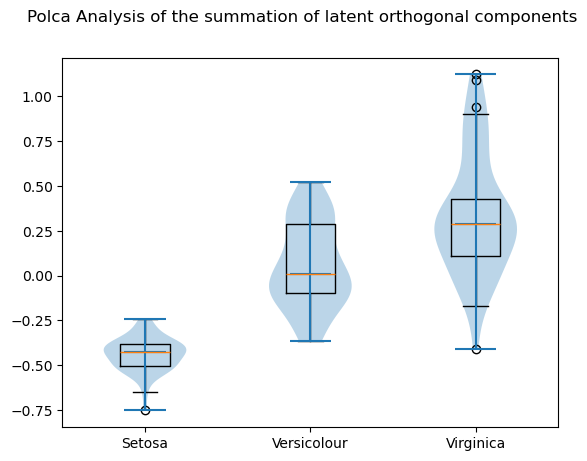

In [81]:
latents, reconstructed = model_iris.predict(X)
vectors = []
labels = ["Setosa", "Versicolour", "Virginica"]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [82]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()
idx = np.arange(latents.shape[1])
idx = -1

with o1:
    scores = model_iris.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last componet with clean data")
    plt.show()

with o2:
    scores = model_iris.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [83]:
model_iris.std_metrics

array([1.0902249 , 0.79528606, 0.12356114, 0.02399455], dtype=float32)

In [84]:
model_iris.mean_metrics

array([-0.7376288 ,  0.559156  ,  0.02096031,  0.14168434], dtype=float32)

In [26]:
def generate_2d_sinusoidal_data(N, M, num_samples):
    data = []
    for _ in range(num_samples):
        x = np.linspace(0, 1, N)
        y = np.linspace(0, 1, M)
        xx, yy = np.meshgrid(x, y)

        # Random phase shifts for x and y directions
        phase_shift_x = np.random.uniform(0, 2 * np.pi)
        phase_shift_y = np.random.uniform(0, 2 * np.pi)

        # Random frequency multipliers for x and y directions
        freq_multiplier_x = np.random.uniform(0.5, 1.5)
        freq_multiplier_y = np.random.uniform(0.5, 1.5)

        # Generate sinusoidal data with random phase and frequency
        z = np.sin(2 * np.pi * freq_multiplier_x * xx + phase_shift_x) * np.cos(2 * np.pi * freq_multiplier_y * yy + phase_shift_y)
        data.append(z)

    return np.array(data).astype(np.float32)

In [27]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data = generate_2d_sinusoidal_data(N, M, num_samples)
data.shape

(1000, 32, 32)

In [98]:
# model = PolcaNet(
#     input_dim=M,
#     latent_dim=256,
#     hidden_dim=None,
#     num_layers=1,
#     autoencoder_type="lstm",
#     seq_len=N,
#     alpha=1.0,  # ortgogonality loss
#     beta=1.0,  # variance sorting loss
#     gamma=1.0,  # variance reduction loss
#     device="cuda",
# )


aencoder_lstm = autoencoder_factory(
    input_dim=M,
    latent_dim=256,
    hidden_dim=None,
    num_layers=3,
    autoencoder_type="lstm",
    seq_len=N,
    act_fn=act_fn,
)

model_lstm = PolcaNet(
    model=aencoder_lstm,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
)

In [100]:
model_lstm.to_device("cuda")
model_lstm.train_model(data=data, batch_size=512, num_epochs=20000, report_freq=10, lr=0.001)

epoch:   0%|          | 0/20000 [00:00<?, ?it/s]

Final metrics at epoch: 19999
loss: 0.005148
decode: 0.0007218
orth: 0.0365
com: 0.0002725
var: 2.368e-05


In [154]:
aencoder_conv2d = autoencoder_factory(
    input_dim=M,
    latent_dim=256,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    seq_len=N,
)

model = PolcaNet(
    model=aencoder_conv2d,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.0,  # variance reduction loss
    device="cuda",
)

In [ ]:
model.to_device("cuda:1")
model.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
model.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-4)

In [ ]:
latents, reconstructed = model.predict(data)
data.shape, reconstructed.shape, latents.shape

In [ ]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

In [ ]:
model.show_correlation_matrix(latents=latents[:, :20])

In [ ]:
model.plot_scatter_corr_matrix(latents, n_components=10)

In [ ]:
model.plot_stdev_pct()

In [ ]:
model.plot_cumsum_variance(data)

In [ ]:
model.analyze_latent_feature_importance(data)

In [ ]:
model.analyze_reconstruction_error(data, n_samples=10000)

In [ ]:
model.analyze_latent_space(data=data)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.stats import gaussian_kde
from tabulate import tabulate

def generate_polcanet_report(model, data, latents=None, max_components=5, max_samples=5000, n_samples=10000):
    """
    Generate a comprehensive report for PolcaNet with various analyses and plots.

    Parameters:
    - model: The PolcaNet model instance
    - data: Input data (numpy array)
    - latents: Latent representations (optional, numpy array)
    - max_components: Maximum number of latent components to analyze (default: 5)
    - max_samples: Maximum number of samples for scatter plot (default: 5000)
    - n_samples: Number of samples for reconstruction error analysis (default: 10000)
    """
    
    if latents is None:
        latents = model.encode(data)
    
    n_components = min(max_components, latents.shape[1])
    variances = np.var(latents, axis=0)[:n_components]
    explained_variance_ratio = variances / np.sum(variances)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Compute required metrics
    corr = np.corrcoef(latents.T)
    off_diag_corr = corr[np.triu_indices_from(corr, k=1)]
    variance_concentration = np.sum(variances * np.arange(n_components, 0, -1)) / (np.sum(variances) * n_components)
    decorrelation_metric = 1 - np.mean(np.abs(off_diag_corr))

    # Set up the plotting area with subplots
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    fig.suptitle("PolcaNet Comprehensive Report", fontsize=16)

    # Plot variance analysis
    axs[0, 0].bar(range(len(explained_variance_ratio)), explained_variance_ratio)
    axs[0, 0].set_title("Explained Variance Ratio")
    axs[0, 0].set_xlabel("Latent Component")
    axs[0, 0].set_ylabel("Variance Ratio")
    
    # Plot cumulative variance ratio
    axs[0, 1].plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    axs[0, 1].set_title("Cumulative Variance Ratio")
    axs[0, 1].set_xlabel("Number of Latent Components")
    axs[0, 1].set_ylabel("Cumulative Variance")

    # Plot correlation matrix
    cax = axs[1, 0].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax, ax=axs[1, 0])
    axs[1, 0].set_title("Correlation Matrix of Latent Components")

    # Scatter plot matrix
    df = pd.DataFrame(latents)
    if len(df) > max_samples:
        df = df.sample(n=max_samples, random_state=42)
    for i in range(1, n_components):
        for j in range(i):
            axs[1, 1].scatter(df.iloc[:, j], df.iloc[:, i], alpha=0.5, s=1)
    axs[1, 1].set_title("Scatter Plot Matrix")
    
    # Plot variance concentration
    axs[2, 0].plot(range(1, len(variances) + 1), 100 * (variances / np.sum(variances)), "o-")
    axs[2, 0].set_title("Stdev Percentage")
    axs[2, 0].set_xlabel("Latent Component")
    axs[2, 0].set_ylabel("Stdev Percentage")
    
    # Analyze reconstruction error
    latents = model.encode(data)
    reconstructed = model.decode(latents)
    errors = np.mean((data - reconstructed) ** 2, axis=1)
    if errors.shape[0] > n_samples:
        indices = np.random.choice(errors.shape[0], n_samples, replace=False)
        errors = errors[indices]
    
    # Ensure errors is a one-dimensional array
    errors = errors.flatten()
    axs[2, 1].hist(errors, bins=50, density=True, alpha=0.7)
    
    # Check if gaussian_kde can be applied
    if errors.shape[0] > 1:
        try:
            kde = gaussian_kde(errors)
            x_range = np.linspace(errors.min(), errors.max(), 1000)
            axs[2, 1].plot(x_range, kde(x_range), 'r-', lw=2)
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError: {e}")
    
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    axs[2, 1].axvline(mean_error, color='g', linestyle='--', label=f'Mean Error: {mean_error:.4f}')
    axs[2, 1].axvline(median_error, color='r', linestyle=':', label=f'Median Error: {median_error:.4f}')
    axs[2, 1].set_title("Reconstruction Error Distribution")
    axs[2, 1].set_xlabel("Reconstruction Error (MSE)")
    axs[2, 1].set_ylabel("Density")
    axs[2, 1].legend()

    # Feature Importance Plots
    feature_importance = np.var(latents, axis=0)
    feature_importance_normalized = feature_importance / np.sum(feature_importance)
    cumulative_importance = np.cumsum(feature_importance_normalized)

    axs[3, 0].bar(range(len(feature_importance_normalized)), feature_importance_normalized)
    axs[3, 0].set_title('Latent Feature Importance (Based on Variance)')
    axs[3, 0].set_xlabel('Latent Feature Index')
    axs[3, 0].set_ylabel('Normalized Variance')
    axs[3, 0].grid(True)

    z = np.polyfit(range(len(feature_importance_normalized)), feature_importance_normalized, 1)
    p = np.poly1d(z)
    axs[3, 0].plot(range(len(feature_importance_normalized)), p(range(len(feature_importance_normalized))), "r--", alpha=0.8)

    axs[3, 1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'bo-')
    axs[3, 1].set_title('Cumulative Latent Feature Importance')
    axs[3, 1].set_xlabel('Number of Latent Features')
    axs[3, 1].set_ylabel('Cumulative Normalized Variance')
    axs[3, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print text-based metrics and interpretation
    print("\n" + "=" * 50)
    print("Latent Space Analysis Report".center(50))
    print("=" * 50 + "\n")

    print("1. General Information")
    print("-" * 30)
    print(f"Number of latent components: {latents.shape[1]}")
    print(f"Total variance in latent space: {np.sum(variances):.4f}")
    print()

    print("2. Variance Analysis")
    print("-" * 30)
    variance_table = [["First component", f"{explained_variance_ratio[0]:.4f}"],
                      ["First 5 components", f"{np.sum(explained_variance_ratio[:5]):.4f}"],
                      ["Components for 95% variance", f"{np.argmax(cumulative_variance_ratio >= 0.95) + 1}"],
                      ["Variance Concentration Metric", f"{variance_concentration:.4f}"]]
    print(tabulate(variance_table, headers=["Metric", "Value"]))
    print("\nVariance Concentration Interpretation:")
    if variance_concentration > 0.8:
        print("Excellent concentration of variance in earlier dimensions.")
    elif variance_concentration > 0.6:
        print("Good concentration of variance, but there might be room for improvement.")
    else:
        print("Poor concentration of variance. The model may need adjustment.")
    print()

    print("3. Orthogonality Analysis")
    print("-" * 30)
    corr_table = [["Mean absolute off-diagonal", f"{np.mean(np.abs(off_diag_corr)):.4f}"],
                  ["Median absolute off-diagonal", f"{np.median(np.abs(off_diag_corr)):.4f}"],
                  ["Max absolute off-diagonal", f"{np.max(np.abs(off_diag_corr)):.4f}"],
                  ["Proportion of |Orthogonality| > 0.1", f"{np.mean(np.abs(off_diag_corr) > 0.1):.4f}"],
                  ["Orthogonality Success Metric", f"{decorrelation_metric:.4f}"]]
    print(tabulate(corr_table, headers=["Metric", "Value"]))
    print("\nOrthogonality Interpretation:")
    if decorrelation_metric > 0.9:
        print("Excellent orthogonality of features.")
    elif decorrelation_metric > 0.7:
        print("Good orthogonality, but there might be room for improvement.")
    else:
        print("Poor orthogonality. The model may need adjustment.")
    print()

    print("4. Detailed Component Analysis")
    print("-" * 30)
    top_n = min(10, latents.shape[1])
    component_table = []
    for i in range(top_n):
        component_table.append([i + 1, f"{explained_variance_ratio[i]:.4f}", f"{cumulative_variance_ratio[i]:.4f}",
                                f"{np.mean(np.abs(corr[i, i + 1:])):.4f}"])
    print(tabulate(component_table, headers=["Component", "Variance Ratio", "Cumulative Variance",
                                             "Mean |Correlation| with Others"]))
    print()
    
# Example usage
# Assuming `polcanet_model` is an instance of PolcaNet and `data` is the input data.
# generate_polcanet_report(polcanet_model, data)


In [ ]:
generate_polcanet_report(model, data=data,max_components=50)